In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Загрузка данных
data = pd.read_csv('kdrama_DATASET_updated.csv')

# Предварительная обработка данных
# Извлечение первого жанра из атрибута Genre
data['Main_Genre'] = data['Genre'].apply(lambda x: x.split(',')[0].strip())

# Кодирование целевого класса
label_encoder = LabelEncoder()
data['Genre_encoded'] = label_encoder.fit_transform(data['Main_Genre'])

# Выбор признаков (используем числовые признаки)
features = ['Rating', 'Number of Episodes', 'Years since release']
X = data[features]
y = data['Genre_encoded']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Масштабирование данных (важно для kNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Обучение модели дерева решений
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)


Оценка для kNN:
Accuracy: 0.2
Precision (macro): 0.08059079176292747
Recall (macro): 0.10279150197628459
F1-score (macro): 0.08694165984724496

Classification Report:
               precision    recall  f1-score   support

       Action       0.17      0.22      0.19        23
    Adventure       0.00      0.00      0.00         1
     Business       0.00      0.00      0.00         4
       Comedy       0.26      0.50      0.34        16
        Drama       0.00      0.00      0.00         1
         Food       0.00      0.00      0.00         2
   Friendship       0.33      0.50      0.40         2
   Historical       0.00      0.00      0.00         7
       Horror       0.00      0.00      0.00         2
          Law       0.00      0.00      0.00         3
     Military       0.00      0.00      0.00         1
        Music       0.00      0.00      0.00         1
      Mystery       0.00      0.00      0.00         6
Psychological       0.00      0.00      0.00         4
      

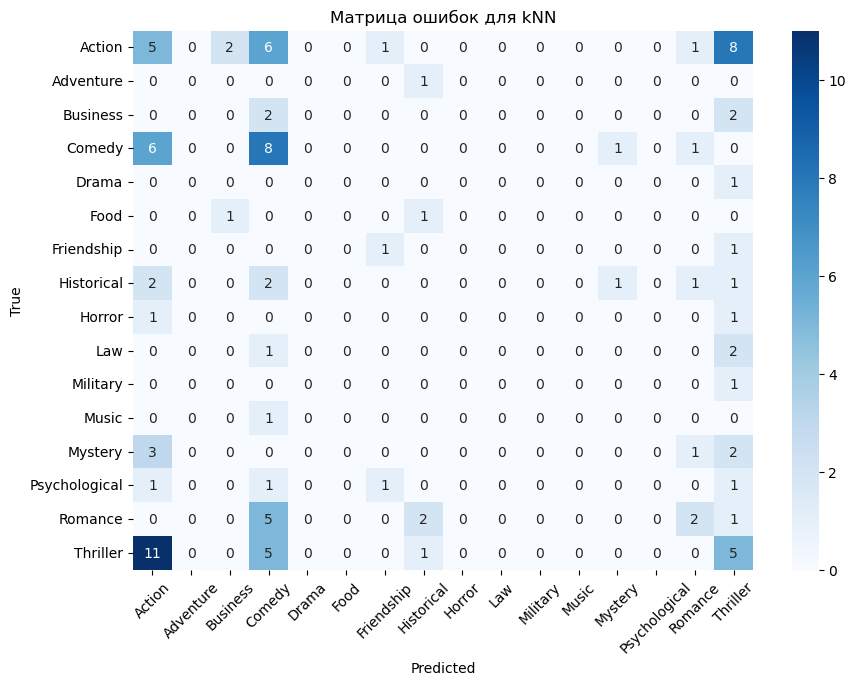


Оценка для дерева решений:
Accuracy: 0.26666666666666666
Precision (macro): 0.13793000477783088
Recall (macro): 0.09621859119141726
F1-score (macro): 0.08516246684350133

Classification Report:
               precision    recall  f1-score   support

       Action       0.57      0.17      0.27        23
    Adventure       0.00      0.00      0.00         1
     Business       0.00      0.00      0.00         4
       Comedy       0.17      0.25      0.21        16
        Drama       0.00      0.00      0.00         1
         Food       0.00      0.00      0.00         2
   Friendship       0.00      0.00      0.00         2
   Historical       0.20      0.14      0.17         7
       Horror       0.00      0.00      0.00         2
          Law       0.00      0.00      0.00         3
     Military       0.00      0.00      0.00         1
        Music       0.00      0.00      0.00         1
      Mystery       0.00      0.00      0.00         6
Psychological       0.00      0.00

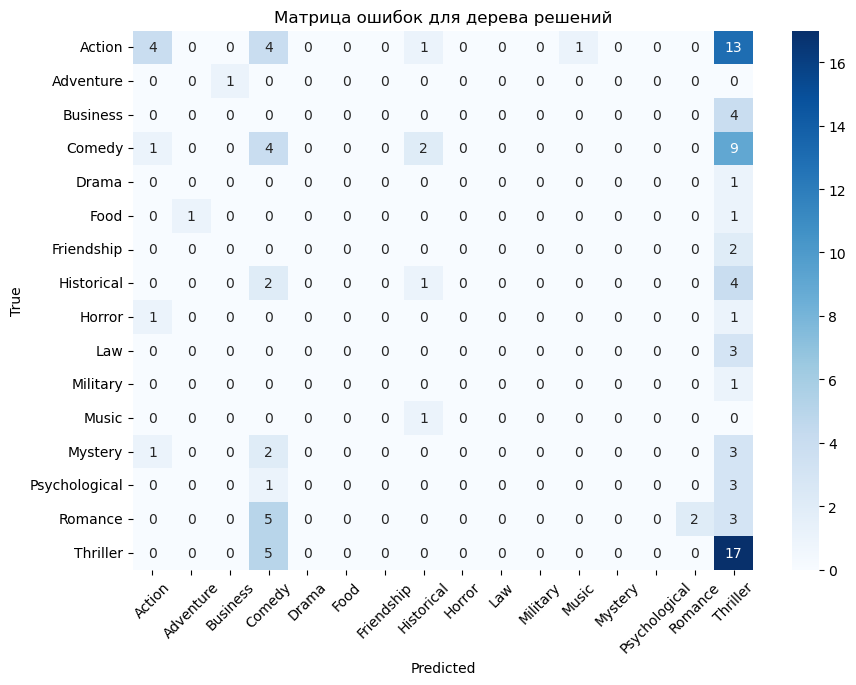

In [12]:
# Оценка моделей
def evaluate_model(y_true, y_pred, model_name):
    # Получаем уникальные классы из y_true и y_pred
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    target_names = [label_encoder.inverse_transform([cls])[0] for cls in unique_classes]
    
    print(f"\nОценка для {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("F1-score (macro):", f1_score(y_true, y_pred, average='macro', zero_division=0))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title(f'Матрица ошибок для {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

evaluate_model(y_test, y_pred_knn, "kNN")
evaluate_model(y_test, y_pred_dt, "дерева решений")

In [13]:
# ROC-кривая (для многоклассовой классификации)
def plot_multiclass_roc(y_true, y_score, model_name):
    # Получаем уникальные классы
    classes = np.unique(y_true)
    
    # Бинаризация выходных данных
    y_test_bin = label_binarize(y_true, classes=classes)
    n_classes = y_test_bin.shape[1]
    
    # Вычисление ROC-кривой и ROC-AUC для каждого класса
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Построение ROC-кривых
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta',
                   'lime', 'pink', 'teal', 'lavender', 'brown', 'orange', 'gray', 'olive'])
    
    for i, color in zip(range(n_classes), colors):
        class_name = label_encoder.inverse_transform([classes[i]])[0]
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC-кривая класса {0} ({1:0.2f} AUC)'
                 ''.format(class_name, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Доля ложно положительных примеров')
    plt.ylabel('Доля истинно положительных примеров')
    plt.title(f'Многоклассовая ROC-кривая для {model_name}')
    plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0))
    plt.show()

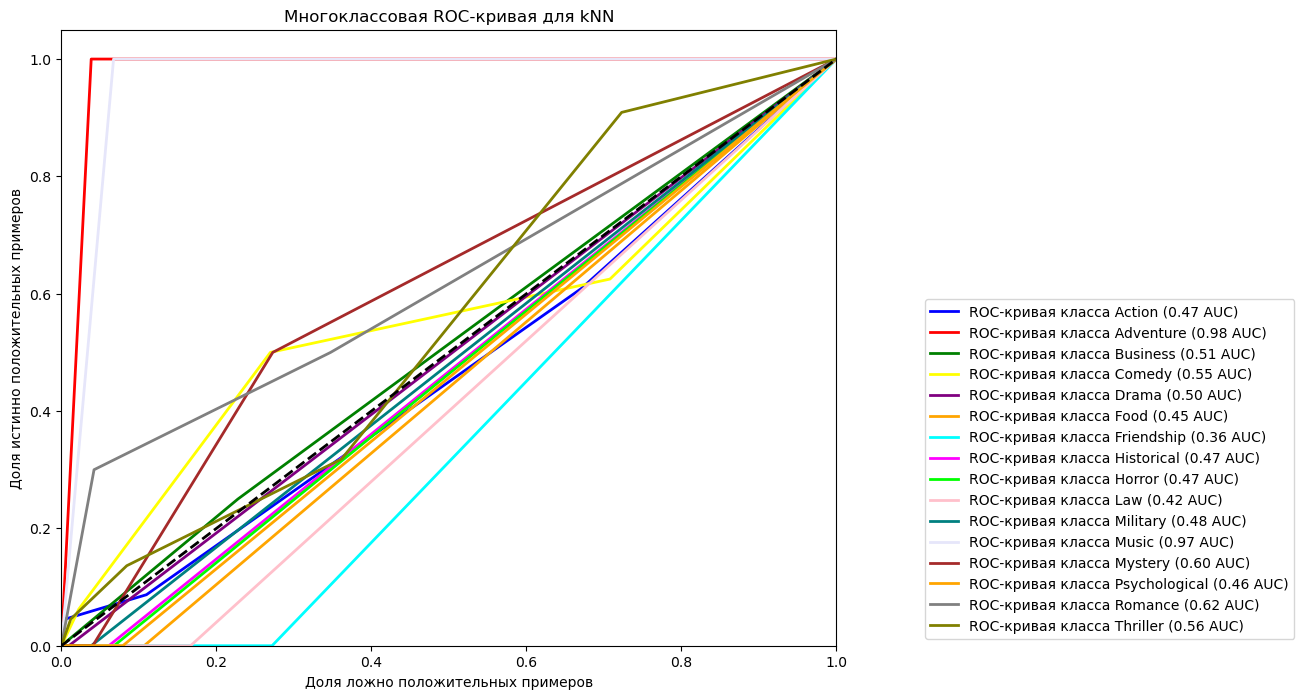

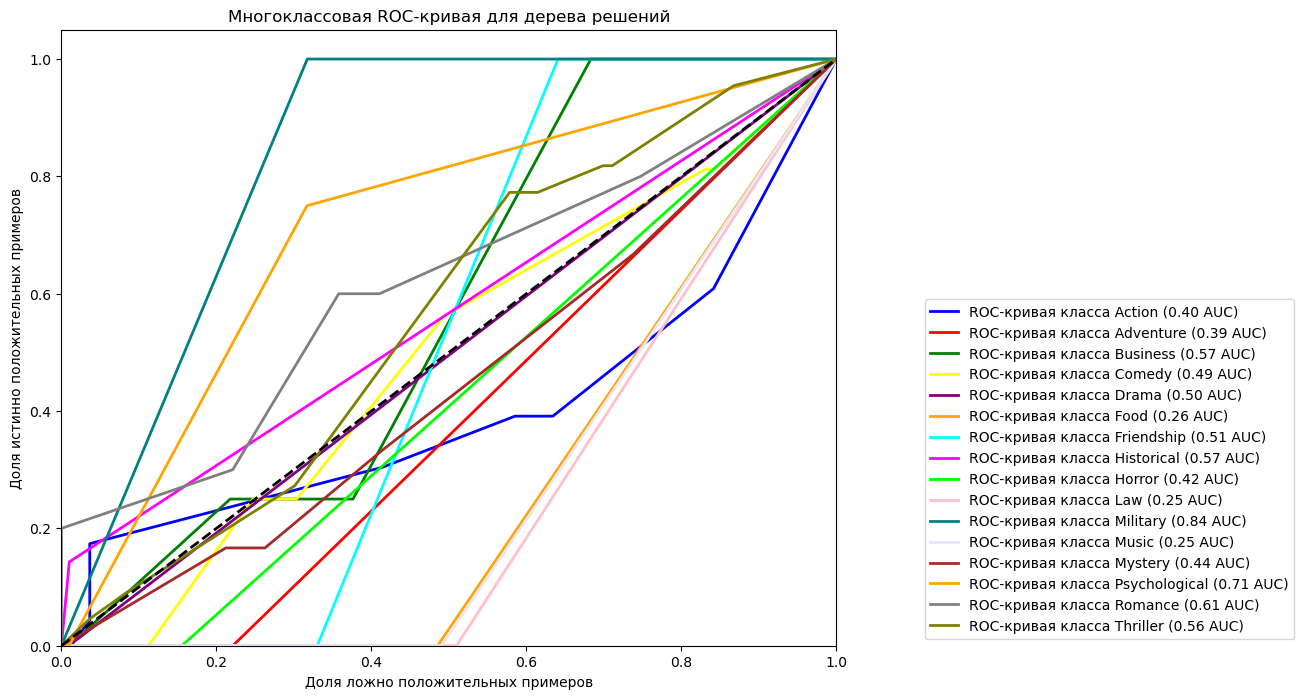

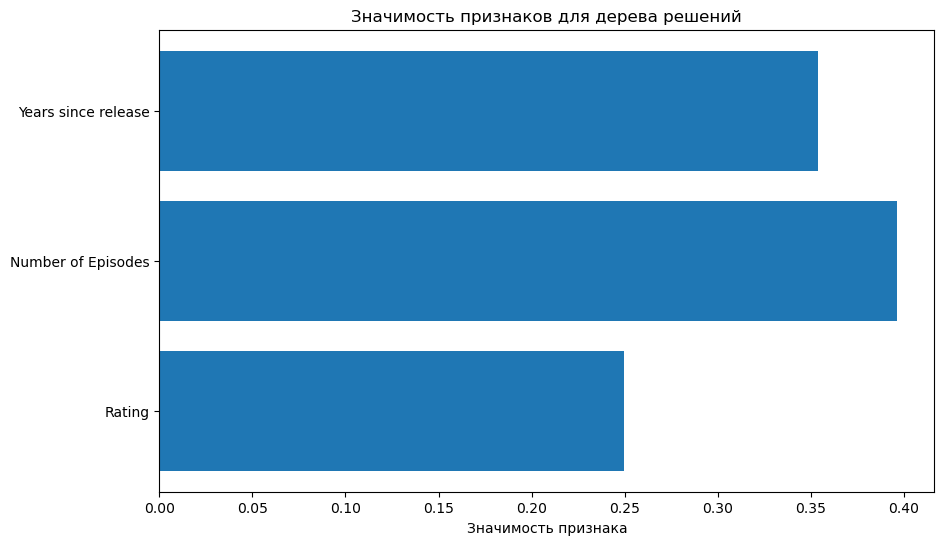

In [14]:
# Для kNN
try:
    y_score_knn = knn.predict_proba(X_test_scaled)
    plot_multiclass_roc(y_test, y_score_knn, "kNN")
except Exception as e:
    print(f"Could not plot ROC for kNN: {e}")

# Для дерева решений
try:
    y_score_dt = dt.predict_proba(X_test)
    plot_multiclass_roc(y_test, y_score_dt, "дерева решений")
except Exception as e:
    print(f"Could not plot ROC for Decision Tree: {e}")

# Визуализация значимости признаков для дерева решений
plt.figure(figsize=(10, 6))
plt.barh(features, dt.feature_importances_)
plt.xlabel('Значимость признака')
plt.title('Значимость признаков для дерева решений')
plt.show()